# Modeling relative strain prevalence

This notebook explores Pyro models for forecasting relative strain prevalance based on GISAID sequence data labeled with Pangolin lineage.

In [1]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Trace_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal, init_to_median
from pyro.optim import ClippedAdam
from pyrophylo.pangolin import merge_lineages, find_edges

DPI = 200

## Loading data

We'll use all GISAID data. You'll need to request a feed from gisaid.org, download, then run
```sh
python preprocess_gisaid.py
```

In [2]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Training on {} rows with columns:".format(len(columns["day"])))
print(", ".join(columns.keys()))

Training on 462530 rows with columns:
accession_id, collection_date, location, add_location, lineage, day


In [3]:
lineages = columns["lineage"]
print(f"Top 12 of {len(set(lineages))} lineages")
print("-" * 30)
for lineage, count in Counter(lineages).most_common(12):
    print(f"{count: >10d} {lineage}")

Top 12 of 867 lineages
------------------------------
     72001 B.1.177
     52067 B.1
     44111 B.1.1.7
     19973 B.1.2
     17483 B.1.1.119
     12190 D.2
     11373 B.1.160
      7575 B.1.1.1
      6581 B.1.1.284
      6379 B.1.177.21
      6109 B
      5039 B.1.258


## Aggregating regions and lineages

We'll aggregate rare lineages into their parents, and aggregate locations by either US state or non-US country.

In [4]:
mapping = merge_lineages(Counter(lineages), min_count=500)
lineages = [mapping.get(x, x) for x in lineages]
print(len(set(lineages)))

108


In [5]:
sparse_data = Counter()
location_id = {}
lineage_id = {}
lineage_id_inv = [None] * len(lineage_id)
for day, location, lineage in zip(columns["day"], columns["location"], lineages):
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = [p.strip() for p in parts[:3]]
    if parts[1] != "USA":
        parts = parts[:2]
    location = " / ".join(parts)
    x = location_id.setdefault(location, len(location_id))
    s = lineage_id.setdefault(lineage, len(lineage_id))
    t = day // 7
    sparse_data[t, x, s] += 1
lineage_id_inv = [None] * len(lineage_id)
for name, i in lineage_id.items():
    lineage_id_inv[i] = name
    
T = 1 + max(columns["day"]) // 7
P = len(location_id)
S = len(lineage_id)
dense_data = torch.zeros(T, P, S)
for (t, p, s), n in sparse_data.items():
    dense_data[t, p, s] = n
print(dense_data.shape)

torch.Size([61, 210, 108])


After aggregation we can define edges relating lineages.

In [6]:
edges = find_edges(list(lineage_id))
edges = torch.tensor([[lineage_id[u], lineage_id[v]] for u, v in edges], dtype=torch.long)

## Constructing a Pyro model

Our first model is a logistic growth model with a Dirichlet-multinomial likelihood (the multivariate generalization of negative binomial likelihood). This accounts for lineage hierarchy but ignores any spatial structure across regions.

In [7]:
def model(dense_data, edges):
    T, P, S = dense_data.shape
    time_plate = pyro.plate("time", T, dim=-2)
    place_plate = pyro.plate("place", P, dim=-1)
    time = torch.arange(float(T)) * 7 / 365.25  # in years
    time -= time.max()
    
    # Assume relative growth rate depends on strain but not time or place.
    log_rate = pyro.sample(
        "log_rate",
        dist.Normal(0, 1).expand([S]).to_event(1).mask(False),
    )
    # Account for hierarchy by assuming related strains have similar growth rate.
    tree_scale = pyro.sample("tree_scale", dist.LogNormal(0, 5))
    with pyro.plate("edges", len(edges), dim=-1):
        u, v = log_rate[edges].unbind(-1)
        pyro.sample(
            "rate_change",
            dist.Normal(0, tree_scale),
            obs=u - v,
        )

    # Assume places differ only in their initial infection count.
    with place_plate:
        log_init = pyro.sample(
            "log_init",
            dist.Normal(0, 10).expand([S]).to_event(1),
        )

    # Finally observe overdispersed counts.
    concentration = pyro.sample("concentration", dist.LogNormal(2, 1))
    base_rate = (log_init + log_rate * time[:, None, None]).softmax(dim=-1)
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.DirichletMultinomial(
                total_count=dense_data.sum(-1).max(),
                concentration=concentration * base_rate,
                is_sparse=True,  # uses a faster algorithm
            ),
            obs=dense_data,
        )

## Fitting the model

We'll use simple MAP estimation via Pyro's SVI and an `AutoDelta` guide. I'm defining a custom initialization function to initialize forecasts to uniformly even rather than random.

In [8]:
def init_loc_fn(site):
    if site["name"] in ("log_init", "log_rate"):
        return torch.zeros(site["fn"].shape())
    return init_to_median(site)

Traning guide with 22790 parameters:
step    0 loss = 9.35	conc. = 7.83	tree_scale = 1.77
step   50 loss = 6.8	conc. = 4.85	tree_scale = 2.49
step  100 loss = 6.5	conc. = 9.67	tree_scale = 3.43
step  150 loss = 6.41	conc. = 12.2	tree_scale = 3.81
step  200 loss = 6.37	conc. = 13.3	tree_scale = 4
step  250 loss = 6.36	conc. = 13.9	tree_scale = 4.12
step  300 loss = 6.34	conc. = 14.2	tree_scale = 4.22
step  350 loss = 6.34	conc. = 14.5	tree_scale = 4.29
step  400 loss = 6.33	conc. = 14.7	tree_scale = 4.35
step  450 loss = 6.33	conc. = 14.8	tree_scale = 4.4
step  500 loss = 6.32	conc. = 15	tree_scale = 4.44
CPU times: user 33.7 s, sys: 3.8 s, total: 37.5 s
Wall time: 20.1 s


Text(0, 0.5, 'loss')

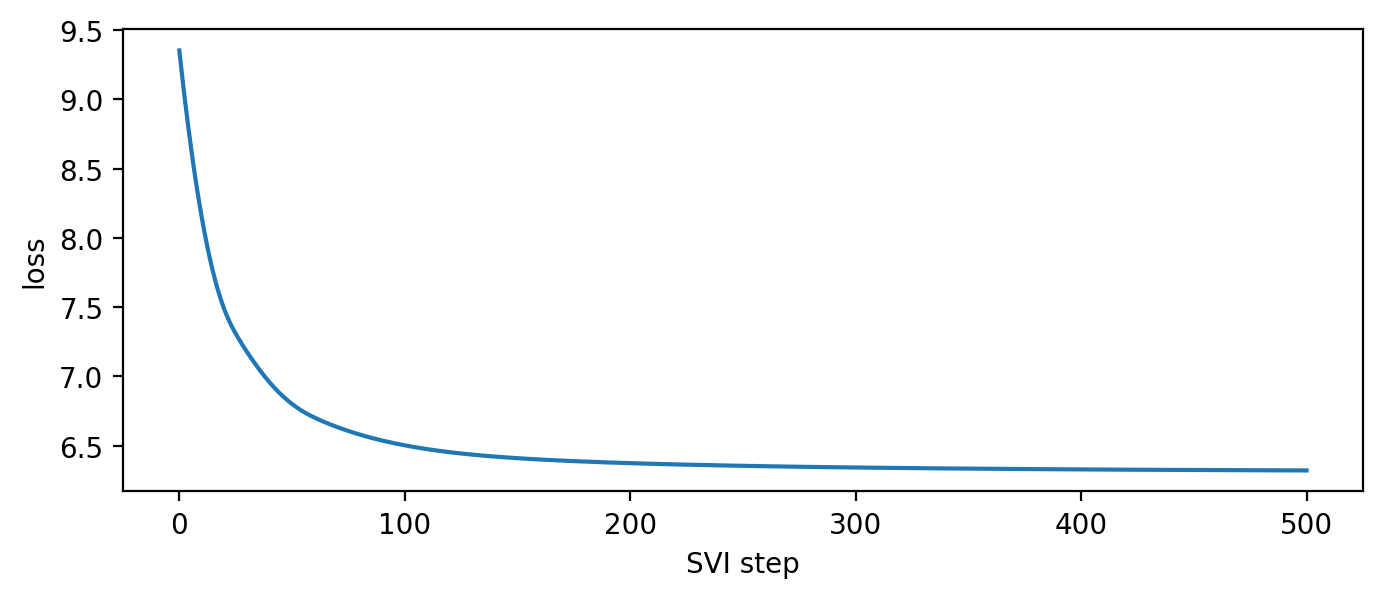

In [9]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(20210204)

num_steps = 501
guide = AutoDelta(model, init_loc_fn=init_loc_fn)
guide(dense_data, edges)  # Initializes guide so we can count parameters.
print("Traning guide with {} parameters:".format(sum(p.numel() for p in guide.parameters())))
optim = ClippedAdam({"lr": 0.05, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
num_obs = dense_data.count_nonzero()
for step in range(num_steps):
    loss = svi.step(dense_data, edges) / num_obs
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        concentration = median["concentration"].item()
        tree_scale = median["tree_scale"].item()
        print(f"step {step: >4d} loss = {loss:0.3g}\t"
              f"conc. = {concentration:0.3g}\ttree_scale = {tree_scale:0.3g}")
        
plt.figure(figsize=(8, 3), dpi=DPI)
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss");

After fitting, we can extract a point estimate via the `guide.median()` method, which returns a dict.

In [10]:
median = guide.median()
print(", ".join(median.keys()))

log_rate, tree_scale, log_init, concentration


## Interpreting results

Since we're fitting relative growth rate and prevalence, we can characterize all lineages by these quantities. Note the relative virulence looks suspciously diverse, suggesting we should probably add process noise to our model.

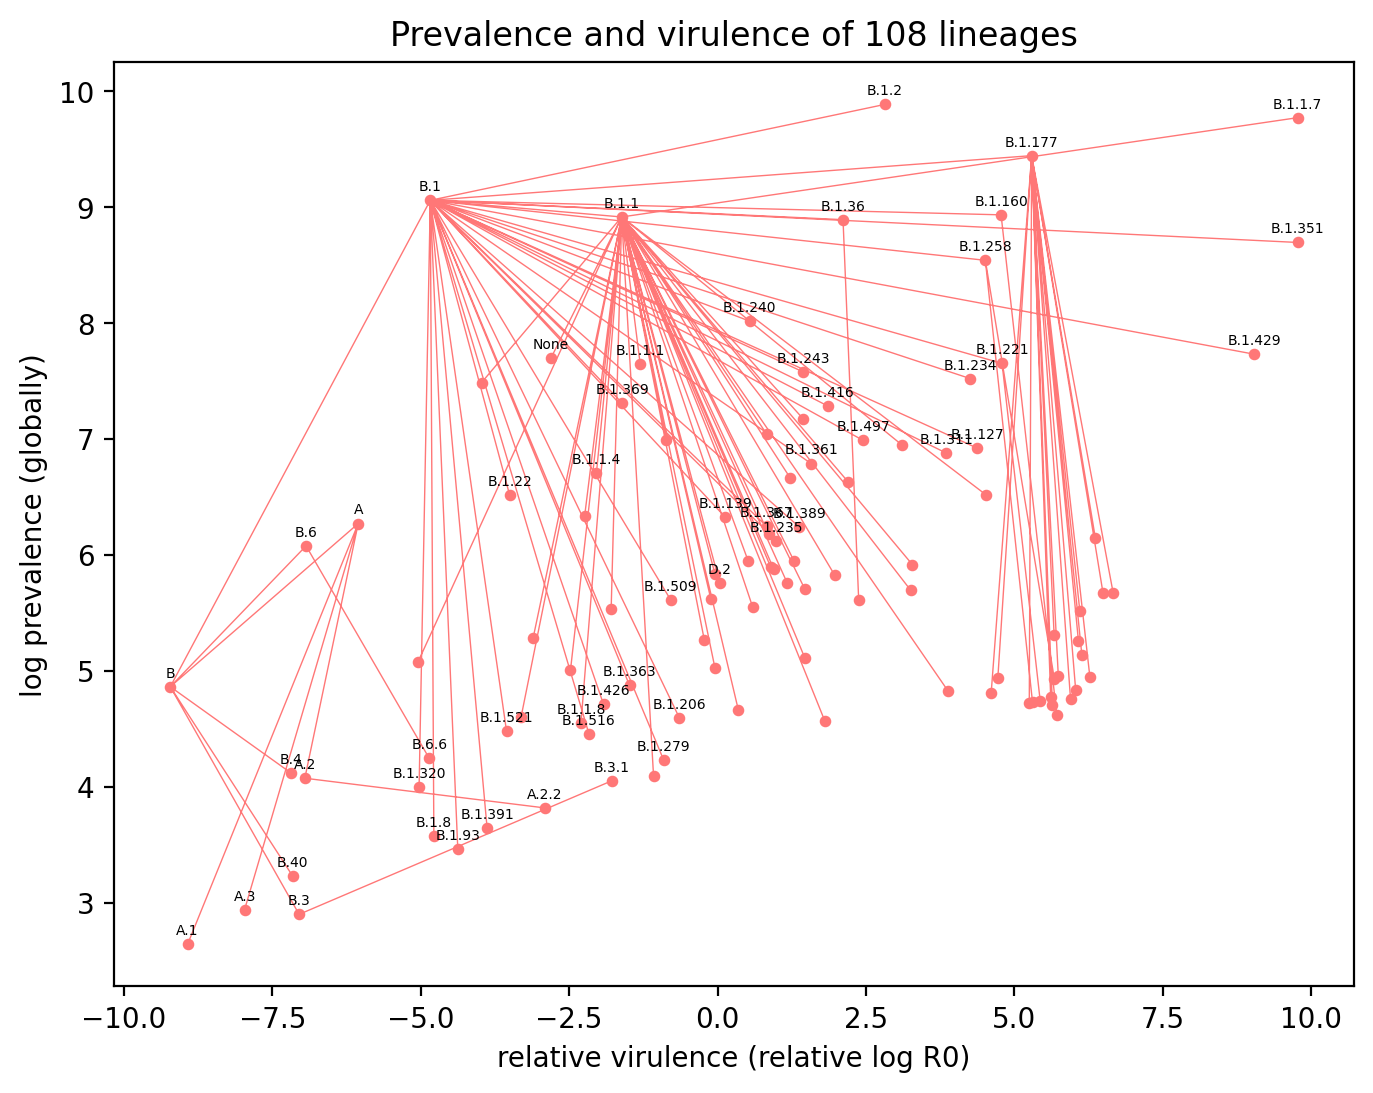

In [11]:
log_rate = median["log_rate"].numpy()
log_init = median["log_init"].logsumexp(0).numpy()
plt.figure(figsize=(8, 6), dpi=DPI)
plt.scatter(log_rate, log_init, s=10, color="#ff7777")
X, Y = [], []
for u, v in edges.tolist():
    X.extend([log_rate[u], log_rate[v], None])
    Y.extend([log_init[u], log_init[v], None])
plt.plot(X, Y, color="#ff7777", lw=0.5)
for name, i in lineage_id.items():
    if len(name) <= 7:
        plt.text(log_rate[i], log_init[i] + 0.08, name,
                 fontsize=5, horizontalalignment="center")
plt.ylabel("log prevalence (globally)")
plt.xlabel("relative virulence (relative log R0)")
plt.title(f"Prevalence and virulence of {len(lineage_id)} lineages");

Finally we can use our logistic curves to forecast lineage prevalence in each region:

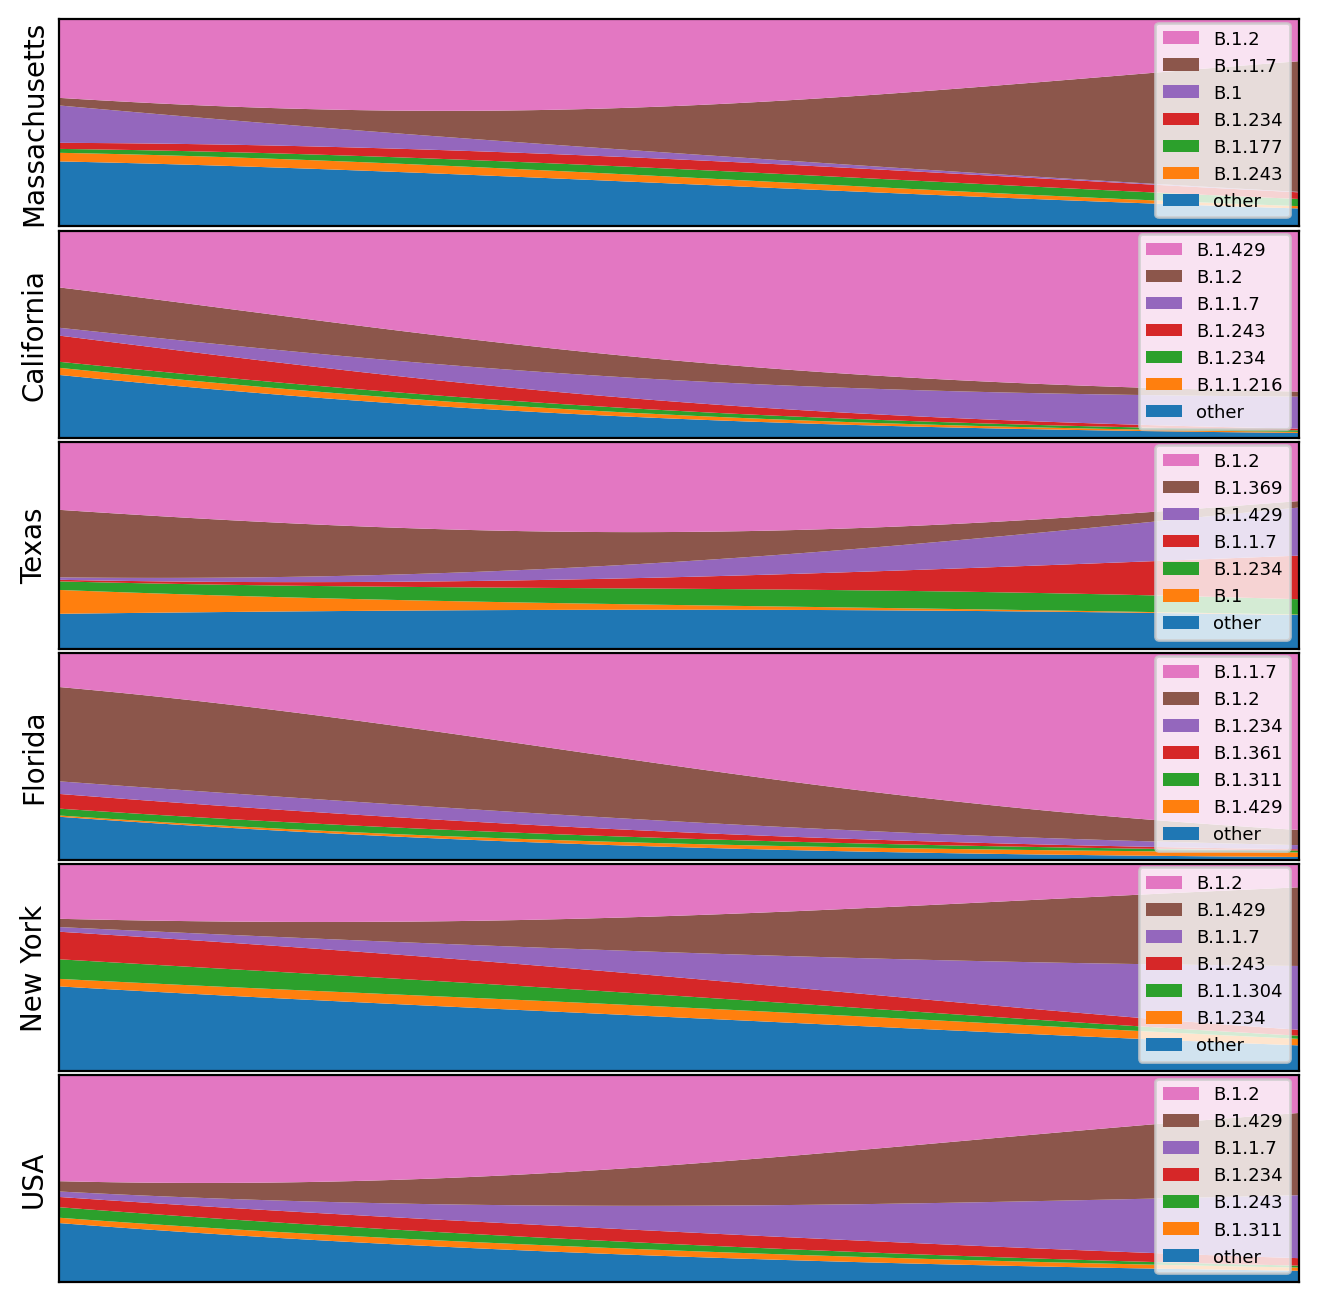

In [12]:
def plot_decomposition(queries, num_parts=7):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)),
                             sharex=True, dpi=DPI)
    for i, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        ids = [location_id[name] for name in names]
        assert ids, "no locations matching " + place_query
        log_rate = median["log_rate"]
        # FIXME this ignores region population when aggregating:
        log_init = median["log_init"][ids].logsumexp(0)
        assert log_init.shape == log_rate.shape
        time = torch.linspace(0, 0.5, 100)
        portion = (log_init + log_rate * time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if i == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        else:
            ax.set_xticks(())
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(["Mass", "Calif", "Texas", "Florida", "New York", "USA"])